## makemore: becoming a backprop ninja

In [ ]:
# there no change change in the first several cells from last lecture

In [1]:
from IPython.display import display, HTML, clear_output

display(HTML("<style>.container { width:100% !important; }</style>"))


from dataclasses import dataclass, field
import typing as t
import itertools as it
import collections as c
import json
from copy import deepcopy
import math
import time
import functools as ft
import numpy as np
import random
from tqdm.notebook import tqdm
import heapq
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.tensorboard as tb

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["font.size"] = 22

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# ok biolerplate done, now we get to the action:

In [8]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [9]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [114]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(low=0, high=Xtr.shape[0]+1, size=(batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
ix

tensor([ 35004, 156252,  94096,  37800,  24686,   2101, 153392,  51800, 119439,
        115216,  52315,  95635,  28832, 175900, 131259, 166755,  26138, 141888,
         43989,   1857,    350, 130503,  28597,  20657, 177075,  67700, 127749,
         67638,  14772,  35990,  20280, 115911])

In [264]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.4192, grad_fn=<NegBackward0>)

In [300]:
Xb.view(-1)

tensor([14, 26,  5,  9, 25,  1,  0,  0,  0,  8,  1, 20,  5,  9, 12,  0,  0,  0,
         0,  0, 11,  0,  0,  5,  9, 19, 20,  0,  0, 12,  1, 21, 14, 24, 12,  5,
         9, 11,  5,  0,  0,  0,  0, 11,  1,  1, 11, 25,  0,  0, 19,  1, 14,  9,
         0, 11,  1,  4,  1, 10,  0, 11, 14,  1,  1, 14, 19,  8, 15,  0,  0, 18,
        12,  5,  5, 15, 14,  9,  0, 26,  9,  0,  0, 13,  0,  0, 11,  0,  0,  0,
         1, 26,  9,  0,  0,  0])

In [321]:
demb.view(-1,demb.shape[-1]).T.unsqueeze(dim=0).shape

torch.Size([1, 10, 96])

In [343]:
"""Vectorised solution to compute gradients of embedding matrix C.

Creating 3D matrics
- Unroll the context words with Xb.view(-1) [1 x 96] and unroll demb.view(-1, 10) [96 x 10]
- We convert Xb into a OHE of dim [27 x 1 x 96] (after appropriate transposing and adding dim)
- We convert demb into a 3D tensor of dim [1 x 10 x 96].

Now when we perform the multiplication of these matrices we will produce a 3D tensor of shape
[27 x 10 x 96]. Such that across the third dimension of training examples we will have exactly
one nonzero row corresponding to the index of the embedding matrix to whom the gradient should flow.
We sum across the third dimension to produce the final gradient matrix.
"""
# 3D Solution
demb_flat = demb.view(-1,demb.shape[-1]).T.unsqueeze(dim=0)  # 1 x 10 x 96 => 10 dim of embed
oh = F.one_hot(Xb.view(-1), num_classes=vocab_size).T.unsqueeze(dim=1)  # 27 x 1 x 96; 96 => 3 ctx words x 32 batch sz
dC3D = (oh * demb_flat)  # 27 x 10 x 96
dC_vec = dC3D.sum(dim=2)
print("Gradient of embedding matrix dC vectorised")
cmp('C', dC_vec, C)

# Compare with iterative solution
dC_it = torch.zeros_like(C)
for cix, grad in zip(Xb.view(-1), demb.view(-1,demb.shape[-1])):
  dC_it[cix] += grad
print("Gradient of embedding matrix dC Iterative")  
cmp('C', dC_it, C)

Gradient of embedding matrix dC vectorised
C               | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
Gradient of embedding matrix dC Iterative
C               | exact: True  | approximate: True  | maxdiff: 0.0


In [344]:
dC_vec[0], dC_it[0]

(tensor([ 0.0048,  0.0022,  0.0148,  0.0255,  0.0097,  0.0018,  0.0057,  0.0065,
         -0.0103, -0.0113]),
 tensor([ 0.0048,  0.0022,  0.0148,  0.0255,  0.0097,  0.0018,  0.0057,  0.0065,
         -0.0103, -0.0113]))

In [350]:
for i in range(27):
  compare_lst =     [
    (round(c1.item(),4), round(c2.item(),4))
    for c1, c2 in zip(dC_it[i], dC_vec[i])
    if not (c1==c2==0.)
  ]
  if compare_lst:
    print(compare_lst)

[(0.0048, 0.0048), (0.0022, 0.0022), (0.0148, 0.0148), (0.0255, 0.0255), (0.0097, 0.0097), (0.0018, 0.0018), (0.0057, 0.0057), (0.0065, 0.0065), (-0.0103, -0.0103), (-0.0113, -0.0113)]
[(0.0134, 0.0134), (0.0128, 0.0128), (-0.0066, -0.0066), (0.0089, 0.0089), (-0.0039, -0.0039), (-0.0144, -0.0144), (-0.0073, -0.0073), (-0.0062, -0.0062), (-0.0017, -0.0017), (0.0153, 0.0153)]
[(0.0049, 0.0049), (-0.001, -0.001), (-0.0002, -0.0002), (-0.0021, -0.0021), (-0.0034, -0.0034), (-0.0043, -0.0043), (0.0035, 0.0035), (0.002, 0.002), (0.0028, 0.0028), (-0.0005, -0.0005)]
[(-0.0092, -0.0092), (-0.0012, -0.0012), (0.0042, 0.0042), (-0.0043, -0.0043), (-0.0029, -0.0029), (0.0015, 0.0015), (-0.0098, -0.0098), (-0.0008, -0.0008), (-0.0085, -0.0085), (0.0071, 0.0071)]
[(-0.0094, -0.0094), (-0.0031, -0.0031), (0.0012, 0.0012), (-0.0068, -0.0068), (0.0081, 0.0081), (0.001, 0.001), (-0.0036, -0.0036), (0.0084, 0.0084), (0.0028, 0.0028), (-0.0003, -0.0003)]
[(0.0157, 0.0157), (0.0008, 0.0008), (-0.0132, -0

In [331]:
dC = torch.zeros_like(C)
for cix, grad in zip(Xb.view(-1), demb.view(-1,demb.shape[-1])):
  dC[cix] += grad
cmp('C', dC, C)

C               | exact: True  | approximate: True  | maxdiff: 0.0


In [293]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one
with torch.no_grad():
  # -----------------
  # YOUR CODE HERE :)
  # -----------------
  dlogprobs = - F.one_hot(Yb, vocab_size).float() * 1/n
  cmp('logprobs', dlogprobs, logprobs)
  dprobs = dlogprobs / probs.data
  cmp('probs', dprobs, probs)
  dcounts_sum_inv = (dprobs * counts.data).sum(dim=1, keepdims=True)
  cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
  dcounts_sum = -dcounts_sum_inv * counts_sum**-2
  cmp('counts_sum', dcounts_sum, counts_sum)
  dcounts = (
    (dcounts_sum)  # (nx1) because all the elements of a row in counts are added, the gradient of the added row simply flows back (addn saves grad)
    + (dprobs * counts_sum_inv) # (nxk) * (nx1)
  )
  cmp('counts', dcounts, counts)
  dnorm_logits = dcounts * counts
  cmp('norm_logits', dnorm_logits, norm_logits)
  dlogit_maxes = -dnorm_logits.sum(dim=1, keepdim=True)
  cmp('logit_maxes', dlogit_maxes, logit_maxes)
  dlogits = dnorm_logits.clone() # (probs.data - F.one_hot(Yb, vocab_size)) * 1/n
  dlogits[range(n), logits.max(1).indices] += dlogit_maxes.squeeze()
  cmp('logits', dlogits, logits)
  dh = dlogits @ W2.T
  cmp('h', dh, h)
  dW2 = h.T @ dlogits
  cmp('W2', dW2, W2)
  db2 = dlogits.sum(dim=0)
  cmp('b2', db2, b2)
  dhpreact = dh * (1-h*h)
  cmp('hpreact', dhpreact, hpreact)
  dbngain =  (dhpreact * bnraw).sum(dim=0, keepdims=True)
  cmp('bngain', dbngain, bngain)
  dbnbias = dhpreact.sum(dim=0)
  cmp('bnbias', dbnbias, bnbias)
  dbnraw = dhpreact * bngain
  cmp('bnraw', dbnraw, bnraw)
  dbnvar_inv = (dbnraw * bndiff).sum(dim=0, keepdims=True)
  cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
  dbnvar = dbnvar_inv * (-0.5) * (bnvar + 1e-5)**(-1.5)
  cmp('bnvar', dbnvar, bnvar)
  dbndiff2 = torch.ones_like(bndiff2) * dbnvar * (1/(n-1))
  cmp('bndiff2', dbndiff2, bndiff2)
  dbndiff = (
    (2 * dbndiff2 * bndiff)
    + dbnraw * bnvar_inv
  )
  cmp('bndiff', dbndiff, bndiff)
  dbnmeani = - dbndiff.sum(axis=0, keepdims=True)
  cmp('bnmeani', dbnmeani, bnmeani)
  dhprebn = (
    dbndiff
    + (torch.ones_like(hprebn) * dbnmeani * (1/n))
  )
  cmp('hprebn', dhprebn, hprebn)
  dembcat = dhprebn @ W1.T
  cmp('embcat', dembcat, embcat)
  dW1 = embcat.T @ dhprebn
  cmp('W1', dW1, W1)
  db1 = dhprebn.sum(axis=0)
  cmp('b1', db1, b1)
  demb = dembcat.view(emb.shape)
  cmp('emb', demb, emb)
  dC = torch.zeros_like(C)
  for cix, grad in zip(Xb.view(-1), demb.view(-1,demb.shape[-1])):
    dC[cix] += grad
  cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [118]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.4191508293151855 diff: -4.76837158203125e-07


In [354]:
# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = (1/n) * (probs.data - F.one_hot(Yb, vocab_size))
# -----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 6.51925802230835e-09


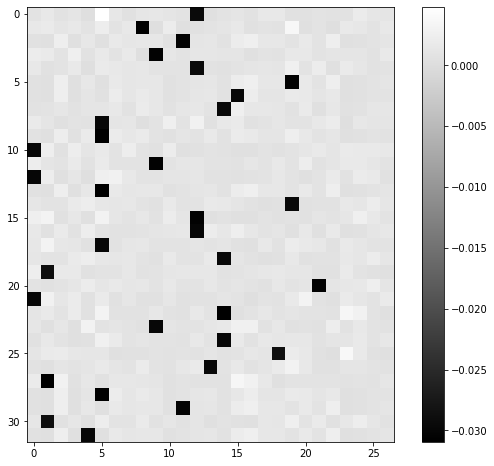

In [359]:
plt.figure(figsize=(10,8))
plt.imshow(dlogits, cmap='gray')
plt.colorbar()

In [360]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [361]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 1.3969838619232178e-09


In [372]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
  #   loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    # YOUR CODE HERE :)
    dlogits = (F.softmax(logits,dim=1) - F.one_hot(Yb, vocab_size)) * 1/n
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(dim=0)
    dhpreact = dh * (1-h*h)
    dbngain =  (dhpreact * bnraw).sum(dim=0, keepdims=True)
    dbnbias = dhpreact.sum(dim=0)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(axis=0)
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for cix, grad in zip(Xb.view(-1), demb.view(-1,demb.shape[-1])):
      dC[cix] += grad
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
  #     p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

12297
      0/ 200000: 3.7900
  10000/ 200000: 2.1867
  20000/ 200000: 2.3885
  30000/ 200000: 2.4745
  40000/ 200000: 1.9757
  50000/ 200000: 2.4217
  60000/ 200000: 2.3510
  70000/ 200000: 2.0539
  80000/ 200000: 2.4223
  90000/ 200000: 2.1433
 100000/ 200000: 2.0089
 110000/ 200000: 2.2877
 120000/ 200000: 2.0273
 130000/ 200000: 2.4873
 140000/ 200000: 2.2530
 150000/ 200000: 2.2041
 160000/ 200000: 2.0072
 170000/ 200000: 1.8101
 180000/ 200000: 2.0145
 190000/ 200000: 1.8702


In [373]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

TypeError: all(): argument 'input' (position 1) must be Tensor, not bool

In [374]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [375]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.069404125213623
val 2.1058788299560547


In [376]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [377]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahza.
jahmerik.
mrix.
taty.
sacarlie.
mahnen.
delynn.
jareei.
nellara.
chaiivon.
leigh.
ham.
joce.
quinn.
shois.
alianni.
watell.
dearyn.
kai.
eveigh.
